# Replay per Epoch with EWC Approach for Continual Learning

In this notebook, we explore a replay per epoch with elastic weight consolidation (EWC) approach for our autonomous driving setting.

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import ntpath

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

## Data Pre-Processing

In [2]:
data_path = 'data'
path = os.path.join(data_path,'driving_log.csv')
data = pd.read_csv(path)

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [4]:
center = data[data.columns[0]].values
left = data[data.columns[1]].values
right = data[data.columns[2]].values
steering = data[data.columns[3]].values

no_of_examples = len(steering)
print("Total Number of Samples :", no_of_examples)

Total Number of Samples : 8036


In [5]:
image_path = 'IMG'
image_path = os.path.join(data_path, image_path)

In [6]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

In [7]:
x = []
y = []

steer_adjust_factor = 0.2
IMAGE_HEIGHT = 100 
IMAGE_WIDTH = 100

for i in range(no_of_examples):
    for choice in range(3):
        if choice == 0: # Center Image
            img = cv2.imread(os.path.join(image_path, center[i]))
            steering_angle = steering[i]
        elif choice == 1: # Left Image
            img = cv2.imread(os.path.join(image_path, left[i]))
            steering_angle = steering[i] + steer_adjust_factor
        elif choice == 2: # Right Image
            img = cv2.imread(os.path.join(image_path, right[i]))
            steering_angle = steering[i] - steer_adjust_factor
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
        img = img[50:,:]
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        x.append(img)
        y.append(steering_angle)
        
        flipped_img, flipped_steering_angle = random_flip(img, steering_angle)
                
        x.append(flipped_img)
        y.append(flipped_steering_angle)

x = np.array(x)
x = np.reshape(x, [x.shape[0], x.shape[1], x.shape[2], 1])

y = np.array(y)
y = np.reshape(y, [y.shape[0],1])

print("x shape :", x.shape)
print("y shape :", y.shape)

x shape : (48216, 100, 100, 1)
y shape : (48216, 1)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_size = x_train.shape[0]
x_test_size = x_test.shape[0]

print("x_train size :", x_train_size)
print("x_test size :", x_test_size)

x_train size : 38572
x_test size : 9644


In [9]:
def get_default_device():
  # Pick GPU, if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # If the instance is a list/tuple, transfer each element to chosen device
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  # non_blocking=True doesn't block the execution of the host device until transfers complete

class DeviceDataLoader():
  # Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
    self.dataset = dl.dataset

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [10]:
# Get the default device
device = get_default_device()
device

device(type='cuda')

We split the dataset into different driving contexts

In [11]:
# Driving Straight Context on Train Dataset
train_straight_idxs = ((y_train <= 0.2) & (y_train >= -0.2)).nonzero()[0].squeeze()

# Driving on Left Curves Context on Train Dataset
train_left_idxs = ((y_train < -0.2) & (y_train >= -0.5)).nonzero()[0].squeeze()

# Driving on Right Curves Context on Train Dataset
train_right_idxs = ((y_train > 0.2 )& (y_train <= 0.5)).nonzero()[0].squeeze()

# Driving on Left Turns Context on Train Dataset
train_sharp_left_idxs = (y_train < -0.5).nonzero()[0].squeeze()

# Driving on Right Turns Context on Train Dataset
train_sharp_right_idxs = (y_train > 0.5).nonzero()[0].squeeze()

In [12]:
# Driving Straight Context on Test Dataset
test_straight_idxs = ((y_test <= 0.2) & (y_test >= -0.2)).nonzero()[0].squeeze()

# Driving on Left Curves Context on Test Dataset
test_left_idxs = ((y_test < -0.2) & (y_test >= -0.5)).nonzero()[0].squeeze()

# Driving on Right Curves Context on Test Dataset
test_right_idxs = ((y_test > 0.2 )& (y_test <= 0.5)).nonzero()[0].squeeze()

# Driving on Left Turns Context on Test Dataset
test_sharp_left_idxs = (y_test < -0.5).nonzero()[0].squeeze()

# Driving on Right Turns Context on Test Dataset
test_sharp_right_idxs = (y_test > 0.5).nonzero()[0].squeeze()

In [13]:
train_contexts = [train_straight_idxs, train_left_idxs, train_right_idxs, train_sharp_left_idxs, train_sharp_right_idxs]
test_contexts = [test_straight_idxs, test_left_idxs, test_right_idxs, test_sharp_left_idxs, test_sharp_right_idxs]

In [14]:
x_train_tensor = torch.Tensor(x_train).permute(0, 3, 1, 2)  # Change channels last to channels first
y_train_tensor = torch.Tensor(y_train)

x_test_tensor = torch.Tensor(x_test).permute(0, 3, 1, 2)  # Change channels last to channels first
y_test_tensor = torch.Tensor(y_test)

## Model

In [15]:
class CNNModel(nn.Module):
    def __init__(self, height, width):
        super(CNNModel, self).__init__()
        
        self.height = height
        self.width = width
        
        # Input normalization
        self.norm = nn.BatchNorm2d(1)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (height // 16) * (width // 16), 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        
        # Dropout and Batch normalization
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.norm(x)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv6(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.batchnorm1(self.fc1(x))
        x = self.batchnorm2(self.fc2(x))
        x = self.batchnorm3(self.fc3(x))
        x = self.fc4(x)
        return x

In [16]:
model = CNNModel(IMAGE_HEIGHT, IMAGE_WIDTH)

In [17]:
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [18]:
print(summary(model, input_size=(1, IMAGE_HEIGHT, IMAGE_WIDTH)))

Layer (type:depth-idx)                   Param #
├─BatchNorm2d: 1-1                       2
├─Conv2d: 1-2                            320
├─Conv2d: 1-3                            9,248
├─Conv2d: 1-4                            18,496
├─Conv2d: 1-5                            36,928
├─Conv2d: 1-6                            73,856
├─Conv2d: 1-7                            147,584
├─MaxPool2d: 1-8                         --
├─Linear: 1-9                            2,359,808
├─Linear: 1-10                           131,328
├─Linear: 1-11                           16,448
├─Linear: 1-12                           65
├─Dropout: 1-13                          --
├─BatchNorm1d: 1-14                      1,024
├─BatchNorm1d: 1-15                      512
├─BatchNorm1d: 1-16                      128
Total params: 2,795,747
Trainable params: 2,795,747
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─BatchNorm2d: 1-1                       2
├─Conv2d: 1-2                         

In [19]:
epochs = 10
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

For EWC: we keep a copy of the model's parameters

In [20]:
prior_model = CNNModel(IMAGE_HEIGHT, IMAGE_WIDTH)
prior_model.load_state_dict(model.state_dict())

prior_model = prior_model.to(device)
if device == 'cuda':
  prior_model = torch.nn.DataParallel(prior_model)
  cudnn.benchmark = True

In [21]:
# EWC hyperparameter
lambda_ewc = 0.01

## Model Training

In [22]:
# Training Helper Function to Format Time
def format_time(seconds):
  days = int(seconds / 3600/24)
  seconds = seconds - days*3600*24
  hours = int(seconds / 3600)
  seconds = seconds - hours*3600
  minutes = int(seconds / 60)
  seconds = seconds - minutes*60
  secondsf = int(seconds)
  seconds = seconds - secondsf
  millis = int(seconds*1000)

  f = ''
  i = 1
  if days > 0:
    f += str(days) + 'D'
    i += 1
  if hours > 0 and i <= 2:
    f += str(hours) + 'h'
    i += 1
  if minutes > 0 and i <= 2:
    f += str(minutes) + 'm'
    i += 1
  if secondsf > 0 and i <= 2:
    f += str(secondsf) + 's'
    i += 1
  if millis > 0 and i <= 2:
    f += str(millis) + 'ms'
    i += 1
  if f == '':
    f = '0ms'
  return f

In [23]:
# Number of past experiences to replay
replay_size = 500  # You can adjust this value based on memory constraints

In [24]:
# Initialize replay buffer
replay_buffer = []

In [25]:
# Function to add experiences to replay buffer
def add_to_replay_buffer(inputs, labels):
    replay_buffer.extend(list(zip(inputs.cpu().numpy(), labels.cpu().numpy())))
    while len(replay_buffer) > replay_size:
        replay_buffer.pop(0)

In [26]:
# Train the model for each context
train_losses_per_context = []

for context_idx, idxs in enumerate(train_contexts):
    print(f"Training for Context {context_idx + 1}")
    
    # Create a dataset for the current context
    x_train_context = x_train_tensor[idxs].to(device)
    y_train_context = y_train_tensor[idxs].to(device)
    
    # Check if replay buffer is not empty and add it to the dataset
    if replay_buffer:
        replay_inputs, replay_labels = map(np.array, zip(*replay_buffer))
        replay_inputs = torch.tensor(replay_inputs, device=device, dtype=torch.float32)
        replay_labels = torch.tensor(replay_labels, device=device, dtype=torch.float32)
        
        x_train_context = torch.cat([x_train_context, replay_inputs], dim=0)
        y_train_context = torch.cat([y_train_context, replay_labels], dim=0)
    
    context_dataset = TensorDataset(x_train_context, y_train_context)
    context_loader = DataLoader(context_dataset, batch_size=64, shuffle=True)

    train_losses = []
    
    # Train the model
    for epoch in range(epochs):
        start_time = time.time()
        
        train_running_loss = 0.0

        model.train()
        
        for inputs, labels in context_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # EWC loss
            ewc_loss = 0
            for name, param in model.named_parameters():
                if name in prior_model.state_dict():
                    ewc_loss += torch.norm(param - prior_model.state_dict()[name]) ** 2
            loss += lambda_ewc * ewc_loss
            
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item() * inputs.size(0)
        
        train_epoch_loss = train_running_loss / len(context_loader.dataset)
        train_losses.append(train_epoch_loss)

        cur_time = time.time()
        epoch_time = cur_time - start_time
        
        print(f'Epoch [{epoch+1}/{epochs}] | Train Loss: {train_epoch_loss:.4f}')
        print(f'Time Taken : {format_time(epoch_time)}')
        print('')

    add_to_replay_buffer(x_train_context, y_train_context)

    # Update the prior model with the current model's parameters after each context
    prior_model.load_state_dict(model.state_dict())
    
    train_losses_per_context.append(train_losses)
    
    print('---')
    print('')

Training for Context 1
Epoch [1/10] | Train Loss: 0.0790
Time Taken : 12s378ms

Epoch [2/10] | Train Loss: 0.0215
Time Taken : 11s406ms

Epoch [3/10] | Train Loss: 0.0210
Time Taken : 11s412ms

Epoch [4/10] | Train Loss: 0.0256
Time Taken : 11s419ms

Epoch [5/10] | Train Loss: 0.0221
Time Taken : 11s406ms

Epoch [6/10] | Train Loss: 0.0213
Time Taken : 11s412ms

Epoch [7/10] | Train Loss: 0.0217
Time Taken : 11s414ms

Epoch [8/10] | Train Loss: 0.0206
Time Taken : 11s419ms

Epoch [9/10] | Train Loss: 0.0208
Time Taken : 11s417ms

Epoch [10/10] | Train Loss: 0.0220
Time Taken : 11s418ms

---

Training for Context 2
Epoch [1/10] | Train Loss: 0.0481
Time Taken : 1s440ms

Epoch [2/10] | Train Loss: 0.0240
Time Taken : 1s425ms

Epoch [3/10] | Train Loss: 0.0230
Time Taken : 1s425ms

Epoch [4/10] | Train Loss: 0.0237
Time Taken : 1s426ms

Epoch [5/10] | Train Loss: 0.0227
Time Taken : 1s426ms

Epoch [6/10] | Train Loss: 0.0246
Time Taken : 1s426ms

Epoch [7/10] | Train Loss: 0.0209
Time Tak

## Model Evaluation

In [27]:
# Evaluate the final trained model on the test subsets for each context
test_losses_per_context = []

for context_idx, idxs_test in enumerate(test_contexts):
    print(f"Evaluating on Test Dataset for Context {context_idx + 1}")
    
    # Create a dataset and dataloader for the current context
    x_test_context = x_test_tensor[idxs_test]
    y_test_context = y_test_tensor[idxs_test]
    
    context_test_dataset = TensorDataset(x_test_context, y_test_context)
    context_test_loader = DataLoader(context_test_dataset, batch_size=64, num_workers=3, pin_memory=True)
    context_test_loader = DeviceDataLoader(context_test_loader, device)
    
    model.eval()
    
    test_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in context_test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
    
    test_context_loss = test_running_loss / len(context_test_loader.dataset)
    test_losses_per_context.append(test_context_loss)
    
    print(f"Test Loss for Context {context_idx + 1} : {test_context_loss:.4f}")
    print('')

Evaluating on Test Dataset for Context 1
Test Loss for Context 1 : 0.0142

Evaluating on Test Dataset for Context 2
Test Loss for Context 2 : 0.0614

Evaluating on Test Dataset for Context 3
Test Loss for Context 3 : 0.0158

Evaluating on Test Dataset for Context 4
Test Loss for Context 4 : 0.2732

Evaluating on Test Dataset for Context 5
Test Loss for Context 5 : 0.0949



In [28]:
# Calculating Overall Test Loss
overall_test_loss = sum(test_losses_per_context) / len(test_losses_per_context)
print(f"Overall Test Loss: {overall_test_loss:.4f}")

Overall Test Loss: 0.0919


Text(0.5, 1.0, 'Loss vs. No. of Iterations')

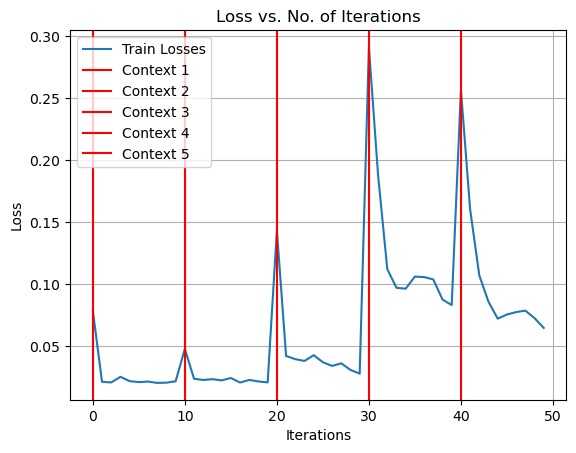

In [29]:
train_losses_flatten = [j for sub in train_losses_per_context for j in sub]

plt.plot(train_losses_flatten, label='Train Losses')
for i in range(1, len(train_contexts) + 1):
    plt.axvline(x=epochs*(i-1), color='r', label=f'Context {i}')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of Iterations')

Text(0.5, 1.0, 'Test Loss vs. Contexts')

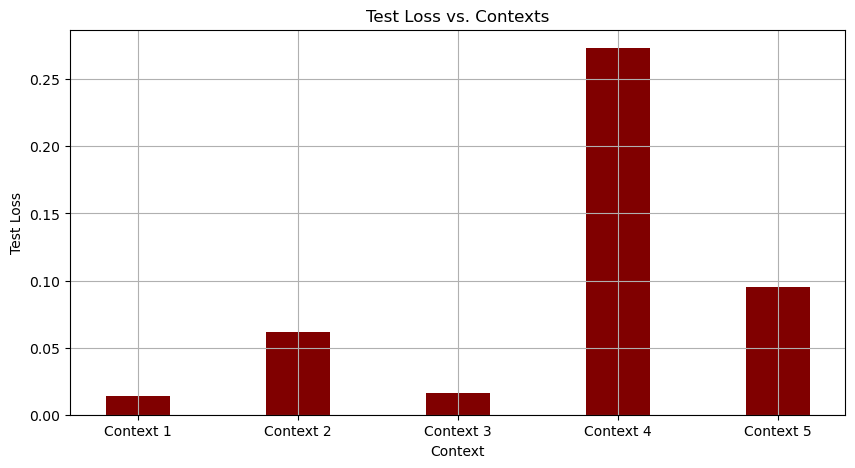

In [30]:
context_list = [f'Context {i+1}' for i in range(len(test_contexts))]

fig = plt.figure(figsize = (10, 5))
plt.bar(context_list, test_losses_per_context, color ='maroon', width = 0.4)
plt.xlabel("Context")
plt.ylabel("Test Loss")
plt.grid(True)
plt.title("Test Loss vs. Contexts")

In [31]:
# Saving model state
state = {
        'model': model.state_dict(),
        'train_losses_per_context': train_losses_per_context,
        'test_losses_per_context': test_losses_per_context,
        'epochs': epochs,
        'lr': lr,
    }

torch.save(state, 'replay_per_epoch_with_ewc_approach.pth')